In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy import stats
import numpy as np
import math

In [2]:
df = pd.read_csv("data/train_cleaned.csv")

LLM generated but verified:

In [3]:
# Nominal categorical features (no inherent order)
nominal_cat_features = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
    'Foundation', 'Heating', 'Electrical', 'CentralAir', 'Functional', 'GarageType', 
    'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'GarageYrBlt'
]

# Ordinal categorical features (have inherent order)
ordinal_cat_features = [
    'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'
]

# Numerical features (continuous)
numerical_continuous_features = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
    'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 
    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
    'MiscVal'
]

# Numerical features (discrete - counts or years)
numerical_discrete_features = [
    'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 
    'MoSold', 'YrSold'
]

all_features = nominal_cat_features + ordinal_cat_features + numerical_continuous_features + numerical_discrete_features

In [4]:
# print(len(list(df.drop(columns='Id').columns)), '\n', len(all_features))

In [5]:
print(f"Numerical discrete Features: {len(numerical_discrete_features)}")
print(f"Numerical continuous Features: {len(numerical_continuous_features)}")
print(f"Categorical nominal Features: {len(nominal_cat_features)}")
print(f"Categorical ordinal Features: {len(ordinal_cat_features)}")

print(f"Total Features: {len(numerical_discrete_features) + len(numerical_continuous_features) + len(nominal_cat_features) + len(ordinal_cat_features)}")

Numerical discrete Features: 13
Numerical continuous Features: 19
Categorical nominal Features: 32
Categorical ordinal Features: 15
Total Features: 79


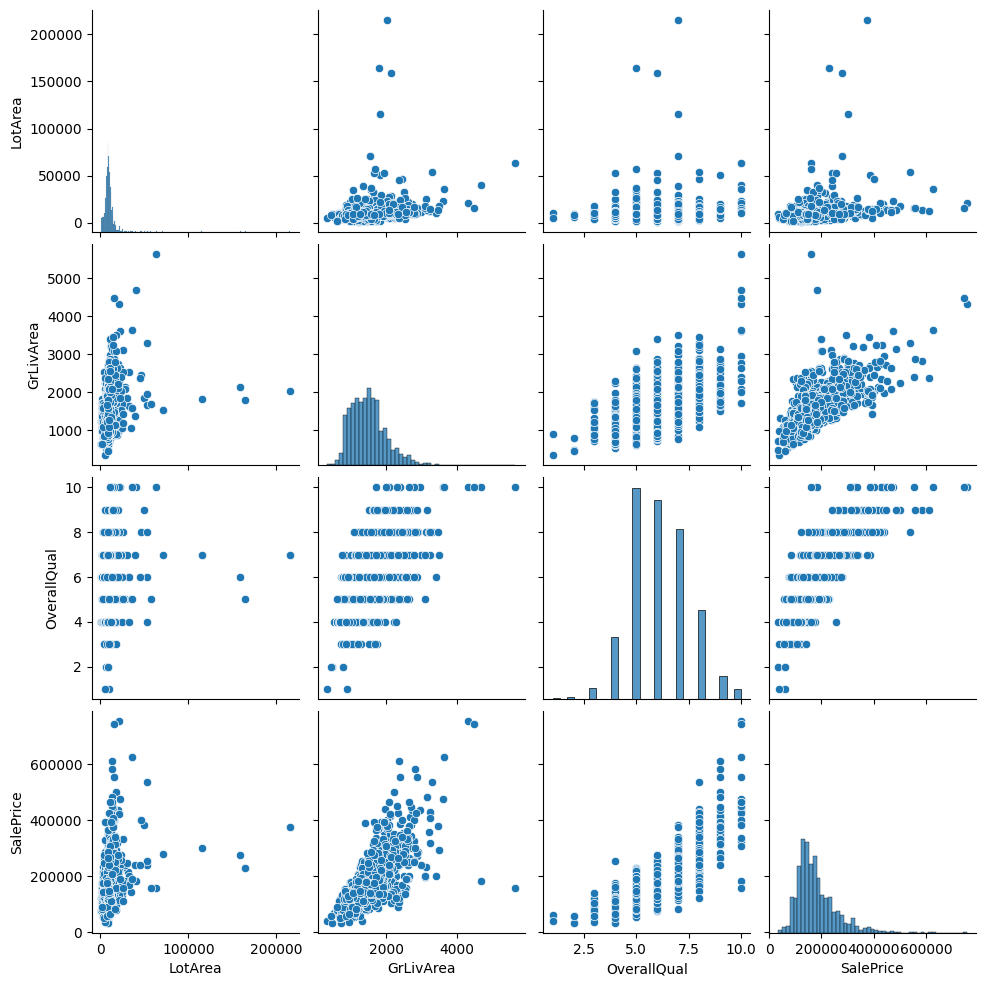

In [6]:
sns.pairplot(df, vars=['LotArea', 'GrLivArea', 'OverallQual', 'SalePrice'])


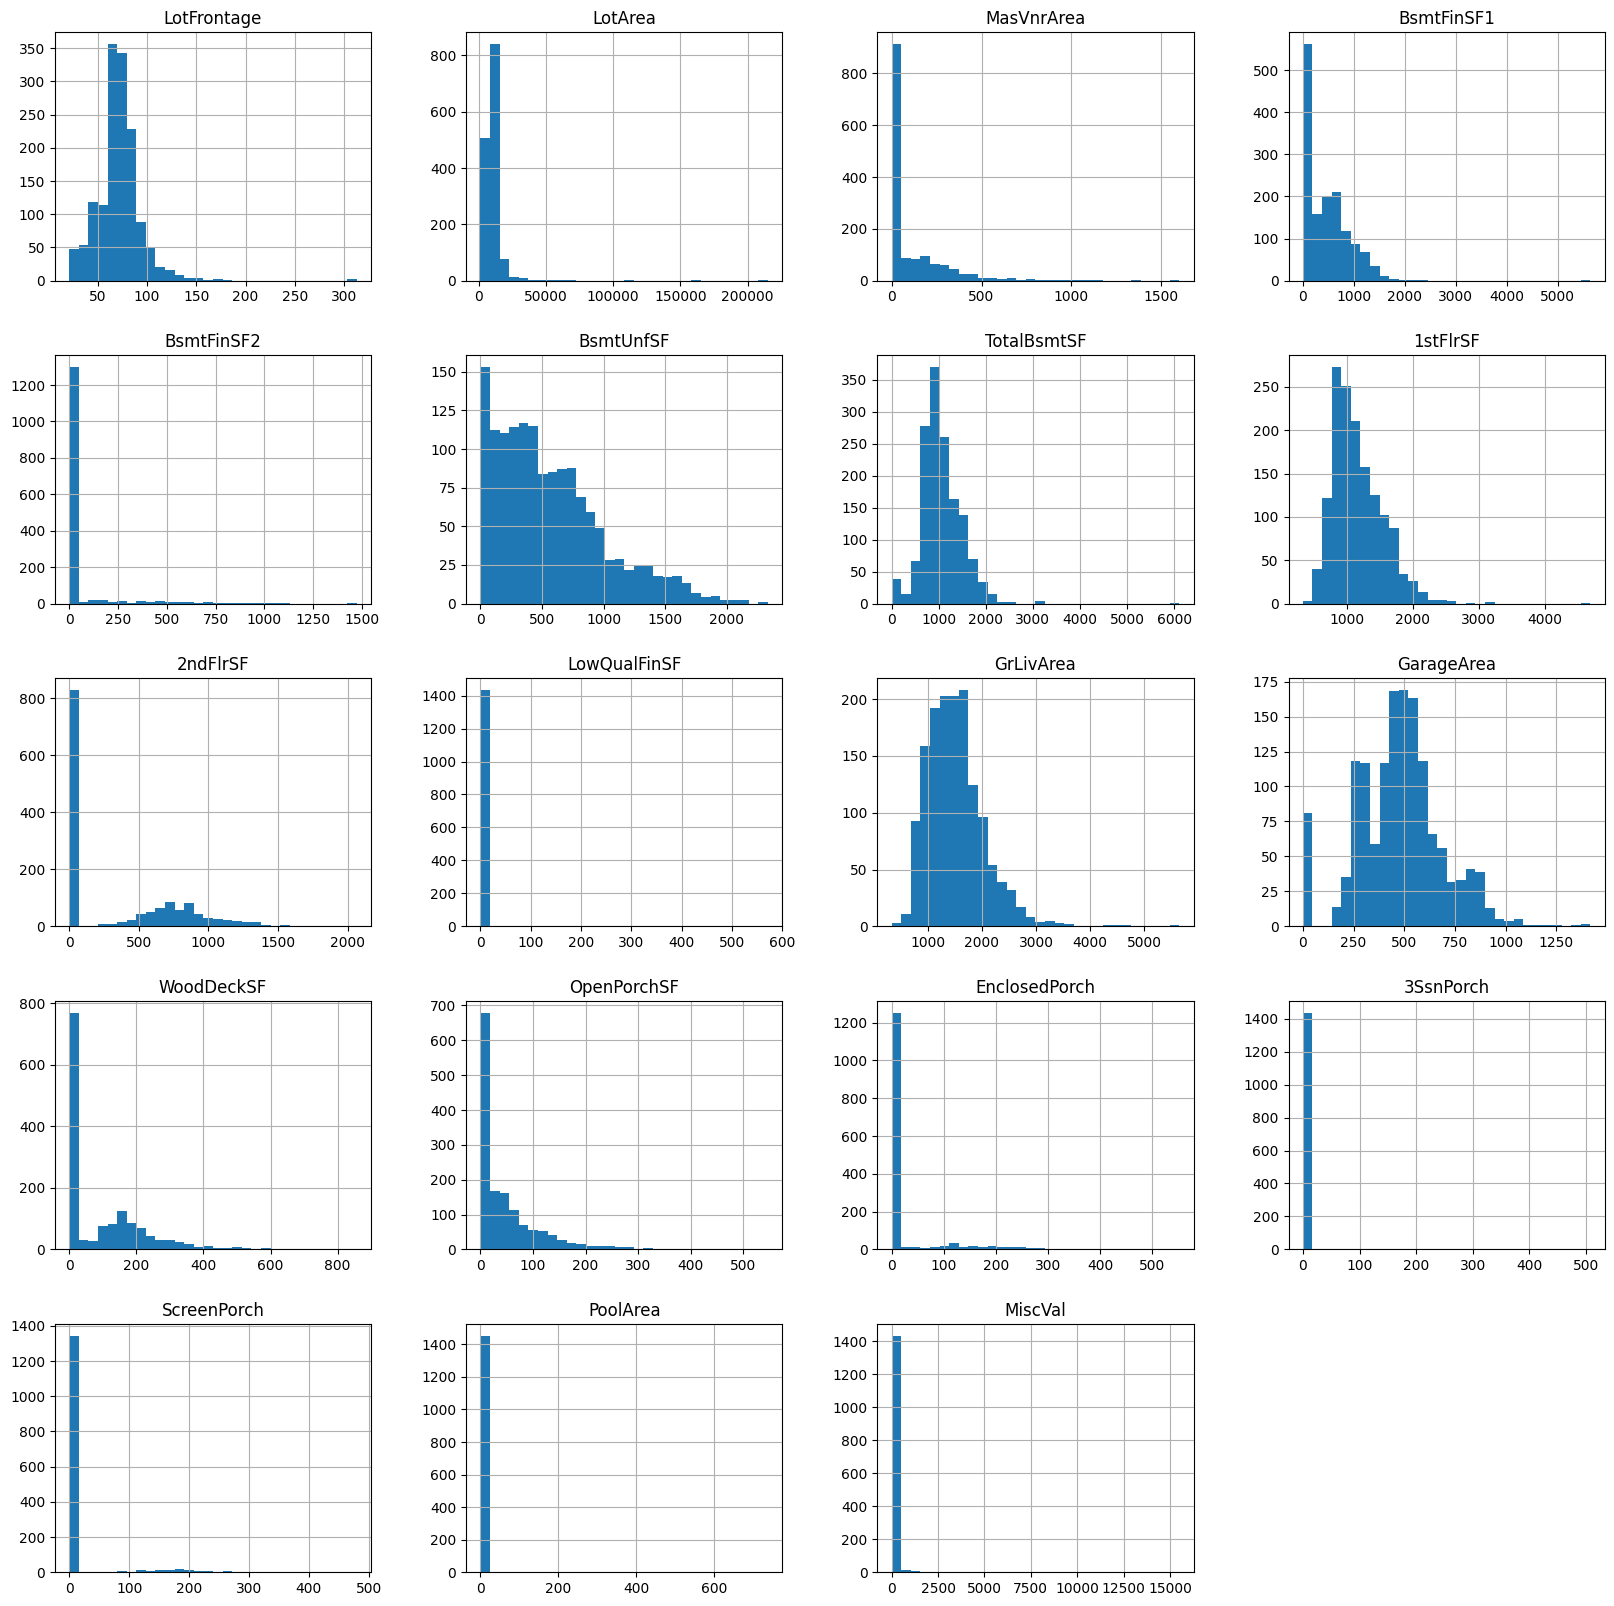

In [7]:
df[numerical_continuous_features].hist(figsize=(20, 20), bins=30)
plt.show()

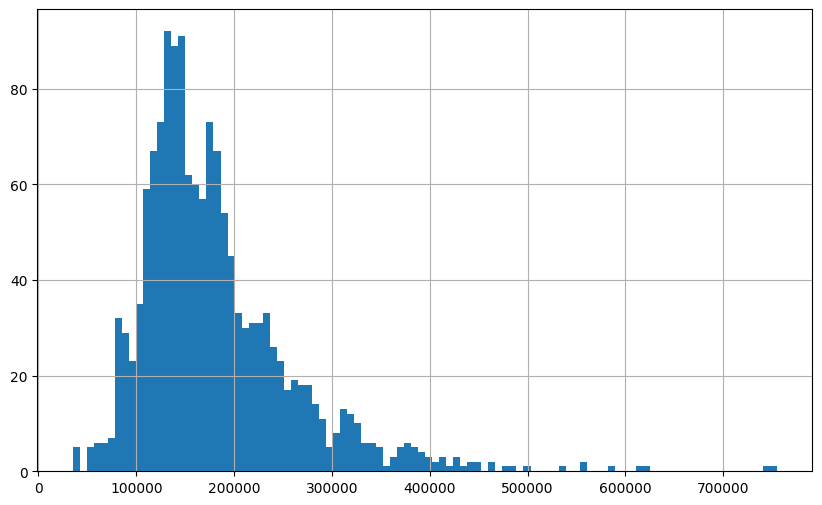

In [8]:
df["SalePrice"].hist(figsize=(10,6), bins=100)
plt.show()

From above we see that most of the numerical features are highly skewed + often span many orders of magnitude (as in SalePrice in (50 000, 750 000)). Examining in detail:

In [9]:
skewness = df[numerical_continuous_features].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skewness[abs(skewness) > 1]
print(f"There are {len(high_skew)} highly Skewed Features:\n", high_skew)

There are 16 highly Skewed Features:
 MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
BsmtFinSF2        4.250888
ScreenPorch       4.117977
EnclosedPorch     3.086696
MasVnrArea        2.674865
OpenPorchSF       2.361912
LotFrontage       2.118499
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


I have verified that Yeo-Johnson is optimal and log1p performs better (less highly skewed features after transformation)

Transformation Summary:
               Original Skewness  Transformed Skewness
MiscVal                24.451640              5.011373
PoolArea               14.813135             14.337930
LotArea                12.195142              0.026542
3SsnPorch              10.293752              7.605922
LowQualFinSF            9.002080              7.291912
BsmtFinSF2              4.250888              2.423157
ScreenPorch             4.117977              3.110067
EnclosedPorch           3.086696              2.045836
MasVnrArea              2.674865              0.425820
OpenPorchSF             2.361912             -0.014757
LotFrontage             2.118499              0.149214
BsmtFinSF1              1.683771             -0.410978
WoodDeckSF              1.539792              0.132139
1stFlrSF                1.375342             -0.001105
GrLivArea               1.365156              0.000171


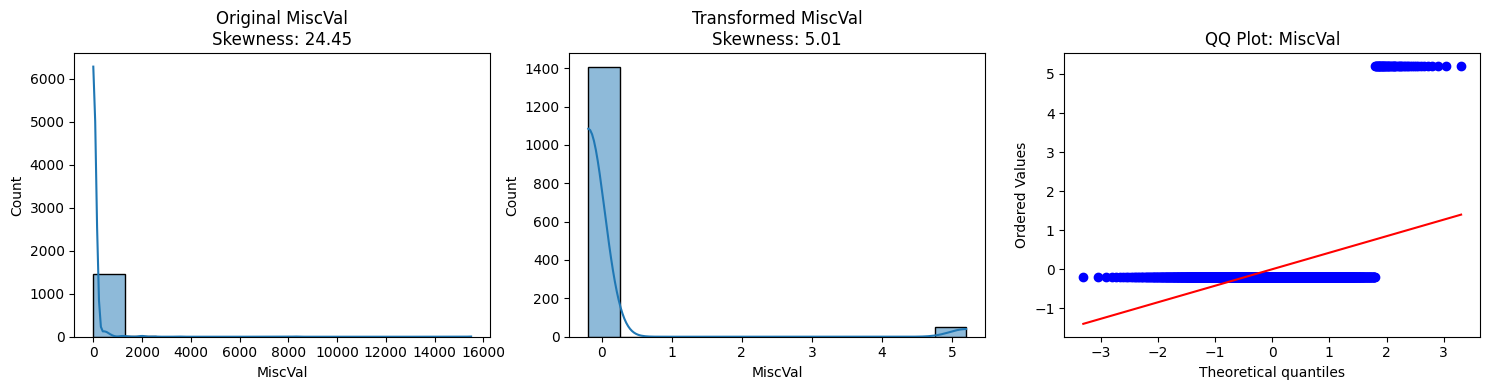

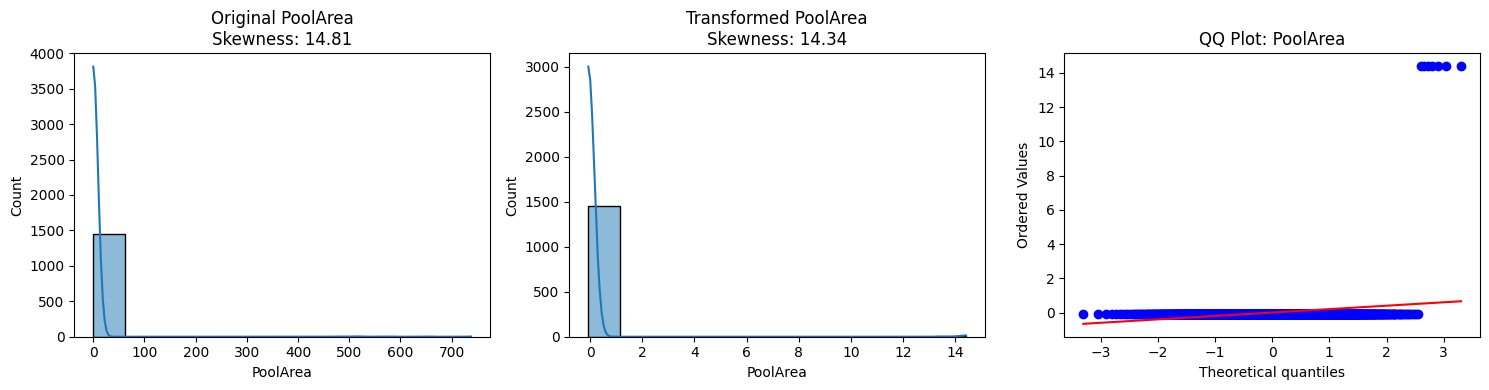

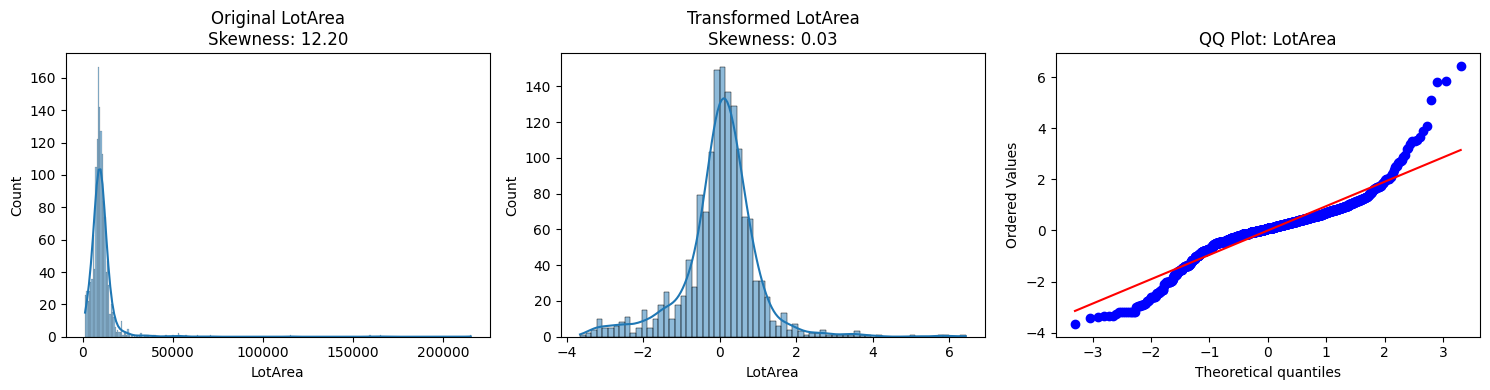

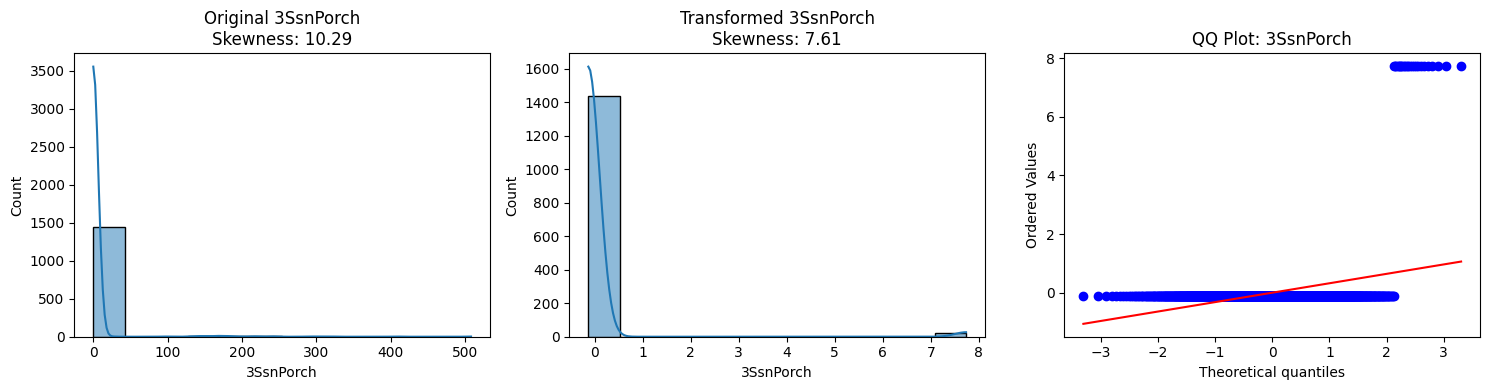

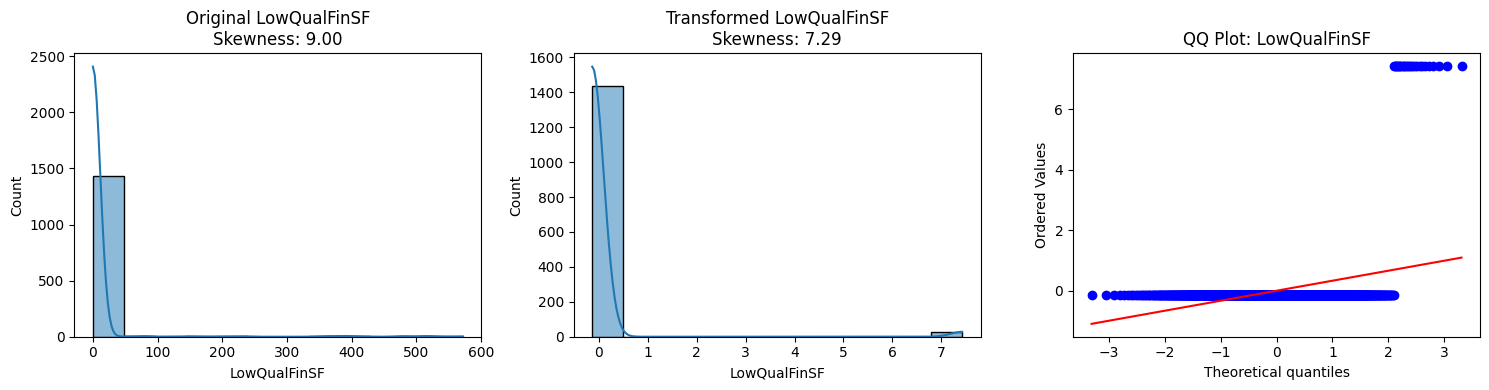

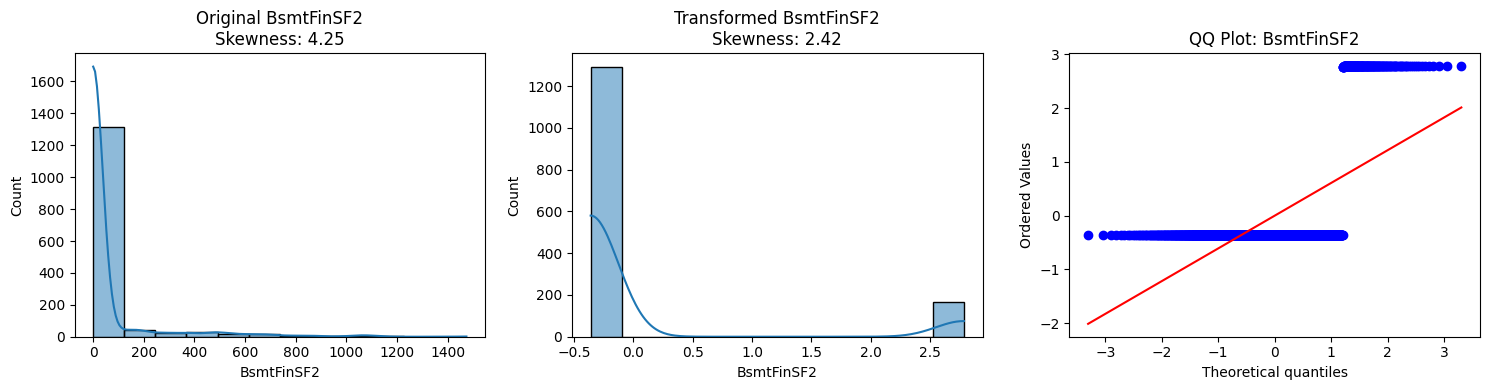

In [10]:
from sklearn.preprocessing import PowerTransformer
from sklearn.mixture import GaussianMixture

df_transformed = df.copy()

# checked that for TotalBsmtSF Log1 does not improve the skewness
features_to_transform = [feature for feature in high_skew.index if feature != 'TotalBsmtSF']

original_skewness = df[features_to_transform].apply(lambda x: stats.skew(x), axis=0)

pt = PowerTransformer(method='yeo-johnson')
transformed_array = pt.fit_transform(df[features_to_transform])



df_transformed[features_to_transform] = pd.DataFrame(transformed_array, columns=features_to_transform, index=df.index)

transformed_skewness = pd.Series({
    feature: stats.skew(df_transformed[feature]) 
    for feature in features_to_transform
})

# Create summary dataframe
transformation_summary = pd.DataFrame({
    'Original Skewness': original_skewness,
    'Transformed Skewness': [transformed_skewness[feature] for feature in features_to_transform]
})

transformation_summary = transformation_summary.sort_values('Original Skewness', ascending=False)

print("Transformation Summary:")
print(transformation_summary)

# Visualize before and after for the top most skewed features
top_features = transformation_summary.index[:6]  # Top 18 most skewed features

for feature in top_features:
    plt.figure(figsize=(15, 4))
    
    # Before transformation
    plt.subplot(1, 3, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Original {feature}\nSkewness: {original_skewness[feature]:.2f}')
    
    # After transformation
    plt.subplot(1, 3, 2)
    sns.histplot(df_transformed[feature], kde=True)
    plt.title(f'Transformed {feature}\nSkewness: {transformed_skewness[feature]:.2f}')
    
    # QQ plot to check normality in at least some of the features
    plt.subplot(1, 3, 3)
    stats.probplot(df_transformed[feature], dist="norm", plot=plt)
    plt.title(f'QQ Plot: {feature}')

    
    plt.tight_layout()
    plt.show()

In [11]:
skewness = df_transformed[numerical_continuous_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

high_skew = skewness[abs(skewness) >1]
print(f"There are {len(high_skew)} highly Skewed Features:\n", high_skew)

There are 8 highly Skewed Features:
 PoolArea         14.337930
3SsnPorch         7.605922
LowQualFinSF      7.291912
MiscVal           5.011373
ScreenPorch       3.110067
BsmtFinSF2        2.423157
EnclosedPorch     2.045836
TotalBsmtSF       1.522688
dtype: float64


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

def detect_outliers_sklearn(df, features, method='isolation_forest', contamination=0.05):
    """
    Detect outliers using scikit-learn methods.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    features : list
        List of numerical features to use
    method : str, default='isolation_forest'
        Method to use: 'isolation_forest', 'lof', or 'elliptic_envelope'
    contamination : float, default=0.05
        Expected fraction of outliers
        
    Returns:
    --------
    pandas.Series
        Boolean Series indicating outliers (True for outliers)
    """
    # Prepare data
    X = df[features].copy()
    # X = X.fillna(X.mean())
    
    # Choose detector
    if method == 'isolation_forest':
        detector = IsolationForest(contamination=contamination, random_state=42)
    elif method == 'lof':
        detector = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    elif method == 'elliptic_envelope':
        detector = EllipticEnvelope(contamination=contamination, random_state=42)
    else:
        raise ValueError("Method must be 'isolation_forest', 'lof', or 'elliptic_envelope'")
    
    # Fit and predict
    if method == 'lof':
        y_pred = detector.fit_predict(X)
    else:
        detector.fit(X)
        y_pred = detector.predict(X)
    
    # Convert to boolean Series (True for outliers)
    outlier_mask = pd.Series(y_pred == -1, index=df.index)
    
    return outlier_mask

def visualize_top_outliers(df, features, outlier_mask, top_n=6, cols=3):
    """
    Visualize the top N features with the most outliers detected by scikit-learn methods.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    features : list
        List of features to visualize
    outlier_mask : pandas.Series
        Boolean Series indicating outliers
    top_n : int, default=6
        Number of features with the most outliers to display
    cols : int, default=3
        Number of columns in the plot grid
    """
    # Count outliers per feature and get top N
    # outlier_counts = {feature: df.loc[outlier_mask, feature].count() for feature in features}
    # top_features = sorted(outlier_counts, key=outlier_counts.get, reverse=True)[:top_n]
    
    selected_features = features[:top_n]
    rows = (len(top_features) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten() if rows * cols > 1 else [axes]
    
    for i, feature in enumerate(selected_features):
        if i < len(axes):
            # Create plot data
            normal_data = df.loc[~outlier_mask, feature]
            outlier_data = df.loc[outlier_mask, feature]
            
            # Box plot for normal data
            sns.boxplot(x=normal_data, ax=axes[i], color='lightblue')
            
            # Scatter points for outliers
            if not outlier_data.empty:
                y = np.zeros(len(outlier_data))  # All at the same y level
                axes[i].scatter(outlier_data, y, color='red', label='Outliers')
            
            axes[i].set_title(f"{feature}")
            axes[i].set_xlabel(feature)
            
            if i == 0:  # Only add legend to first plot
                axes[i].legend()
    print(f' There are: {len(outlier_data)} outliers')
    
    # Remove empty subplots
    for j in range(len(top_features), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def remove_outliers_sklearn(df, outlier_mask):
    """
    Remove outliers detected by scikit-learn methods.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    outlier_mask : pandas.Series
        Boolean Series indicating outliers
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with outliers removed
    """
    # Create a copy to avoid modifying the original
    cleaned_df = df.loc[~outlier_mask].copy()
    
    print(f"Original data shape: {df.shape}")
    print(f"Cleaned data shape: {cleaned_df.shape}")
    print(f"Removed {outlier_mask.sum()} outliers ({outlier_mask.mean()*100:.2f}% of data)")
    
    return cleaned_df


 There are: 30 outliers


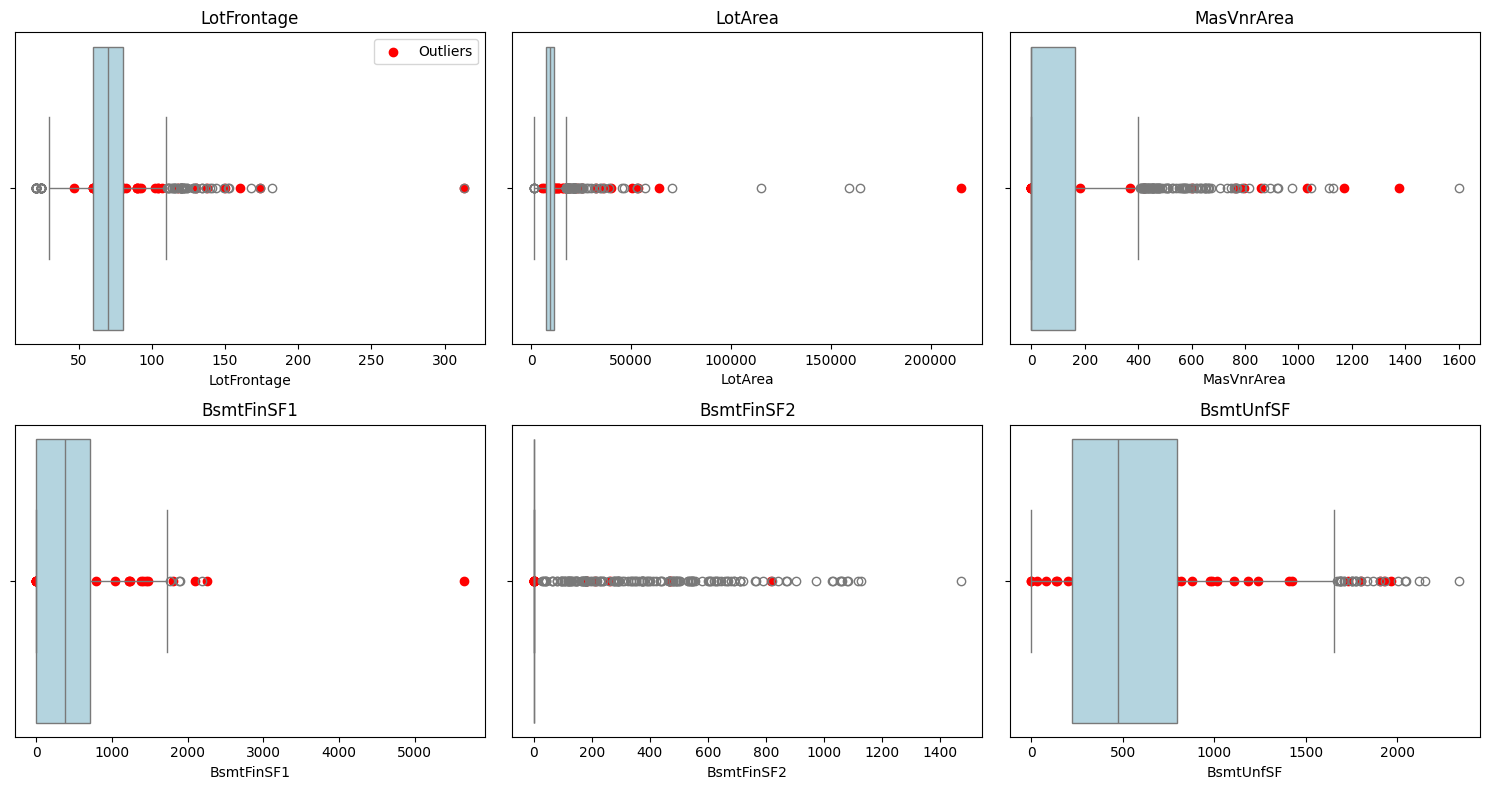

Original data shape: (1460, 80)
Cleaned data shape: (1430, 80)
Removed 30 outliers (2.05% of data)


In [13]:
outlier_mask = detect_outliers_sklearn(
    df, 
    numerical_continuous_features + numerical_discrete_features,
    method='isolation_forest',  
    contamination=0.02  # Adjusted based on simple models performance
)

visualize_top_outliers(df, numerical_continuous_features, outlier_mask, top_n=6)

cleaned_df = remove_outliers_sklearn(df, outlier_mask)

In [14]:
cleaned_df.to_csv('data/train_rm_OL.csv', index=False)

# Correlation analysis

In [15]:
# Correlation with target variable
# corr_with_target = df_transformed[num_features].corrwith(df_transformed["SalePrice"]).sort_values(ascending=False)
corr_with_target = df_transformed[numerical_continuous_features].corrwith(df_transformed["SalePrice"]).sort_values(ascending=False)

# Show highly correlated features (above 0.5) and weakly correlated (below 0.1)
print("Highly Correlated Features with SalePrice:\n", corr_with_target[corr_with_target > 0.5])
print("\nWeakly Correlated Features:\n", corr_with_target[abs(corr_with_target) < 0.1])


Highly Correlated Features with SalePrice:
 GrLivArea      0.695363
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.588290
dtype: float64

Weakly Correlated Features:
 PoolArea        0.093708
ScreenPorch     0.087144
3SsnPorch       0.046015
LowQualFinSF   -0.047932
BsmtFinSF2     -0.052960
MiscVal        -0.068374
dtype: float64


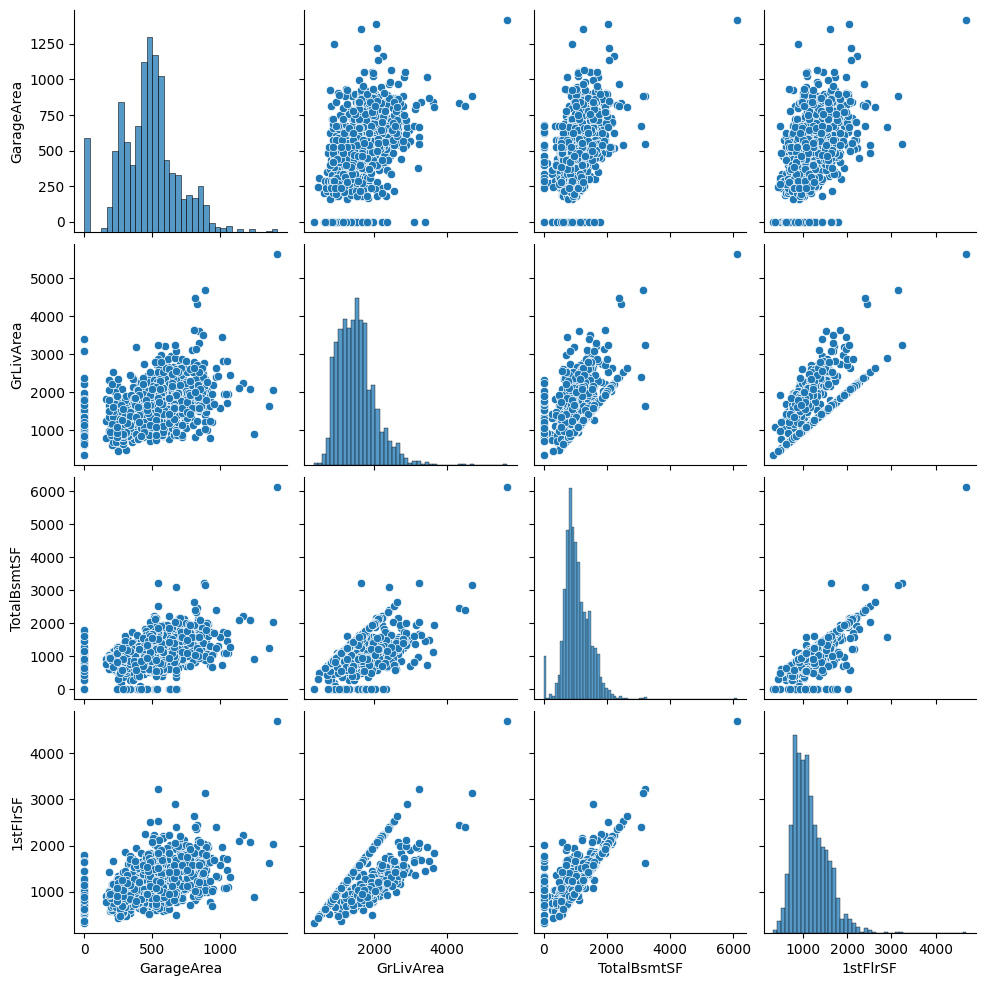

In [16]:
sns.pairplot(df, vars=['GarageArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF'])


In [ ]:
# Select only the predictor variables (exclude 'SalePrice')
predictors = df[numerical_continuous_features]#.drop('SalePrice', axis=1)

# Calculate the correlation matrix for the predictors
correlation_matrix = df[numerical_continuous_features].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Predictor Variables')
plt.show()

Those correlations between features are not huge, so for now I leave it as it is

# Categorical features

In [ ]:
def analyze_categorical_features(df_input, cat_features, target='SalePrice', columns_to_drop=None, alpha=0.01):
    """
    Main function to analyze categorical features with option to drop columns
    Uses F-statistic to analyze multiple features simultaneously
    
    Parameters:
    -----------
    df_input : DataFrame
        The input dataframe to analyze
    cat_features : list
        List of categorical feature names
    target : str
        Target variable name
    columns_to_drop : list, optional
        List of column names to drop from the analysis
    alpha : float, optional
        Significance level for statistical tests (default: 0.01)
    """
    df = df_input.copy()
    
    if columns_to_drop is not None and len(columns_to_drop) > 0:
        df = df.drop(columns=columns_to_drop)
        print(f"Dropped columns: {columns_to_drop}")
        
        # Update cat_features to remove any dropped columns
        cat_features = [col for col in cat_features if col not in columns_to_drop]
        print(f"Remaining categorical features: {len(cat_features)}")
    
    # Reference line
    global_avg_price = df[target].mean()
    
    # Analyze a single categorical feature
    def analyze_categorical_feature(col):
        plt.figure(figsize=(14, 6))
        
        # Plot 1: Distribution of categories
        plt.subplot(1, 2, 1)
        counts = df[col].value_counts()
        sns.countplot(y=col, data=df, order=counts.index)
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        
        # Plot 2: Relationship with target
        plt.subplot(1, 2, 2)
        # Sort categories by their mean price
        cat_means = df.groupby(col)[target].mean().sort_values()
        cat_order = cat_means.index
        
        # Create box plot with sorted categories
        sns.boxplot(x=col, y=target, data=df, order=cat_order)
        plt.axhline(global_avg_price, color='r', linestyle='--', label=f'Avg {target}: ${global_avg_price:,.0f}')
        plt.legend()
        plt.title(f'{target} by {col}')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate statistics
        stats_df = df.groupby(col)[target].agg(['count', 'mean', 'median', 'std']).sort_values('mean', ascending=False)
        
        # Add percent diff from global average
        stats_df['diff_from_avg'] = ((stats_df['mean'] - global_avg_price) / global_avg_price * 100).round(1)
        stats_df = stats_df.rename(columns={'diff_from_avg': '% diff from avg'})
        
        print(f"\nStatistics for {col}:")
        print(stats_df)
        
        # Get F-statistic from the full model
        feature_stats = perform_f_test_for_features([col])
        print(f"F-statistic p-value: {feature_stats['p_value']:.6f} {'(Significant)' if feature_stats['p_value'] < alpha else '(Not significant)'}")
        
        return None
    
    # Function to perform F-test for multiple features
    def perform_f_test_for_features(features):
        """
        Perform F-test for a set of categorical features to determine their joint significance
        """
        import statsmodels.api as sm
        from statsmodels.formula.api import ols
        
        # Create formula for the full model with all features
        formula = f"{target} ~ " + " + ".join(features)
        
        # Fit the model
        try:
            model = ols(formula, data=df).fit()
            f_stat = model.fvalue
            p_value = model.f_pvalue
            r_squared = model.rsquared
            
            return {
                'features': features,
                'f_statistic': f_stat,
                'p_value': p_value,
                'r_squared': r_squared
            }
        except Exception as e:
            print(f"Error fitting model for {features}: {e}")
            return {
                'features': features,
                'f_statistic': float('nan'),
                'p_value': 1.0,
                'r_squared': 0.0
            }
    
    # Function to prioritize categorical features using F-statistic
    def prioritize_categorical_features():
        feature_stats = []
        
        # Calculate F-statistic for each feature individually
        for col in cat_features:
            stats = perform_f_test_for_features([col])
            
            # Calculate max price difference between categories
            cat_means = df.groupby(col, observed=False)[target].mean()
            price_range = cat_means.max() - cat_means.min() if len(cat_means) > 0 else 0
            
            feature_stats.append({
                'Feature': col,
                'F_statistic': stats['f_statistic'],
                'p_value': stats['p_value'],
                'r_squared': stats['r_squared'],
                'Price_Range': price_range,
            })
        
        # Create DataFrame from statistics
        stats_df = pd.DataFrame(feature_stats)
        
        # Sort by statistical significance (p-value)
        stats_df = stats_df.sort_values('p_value')
        
        return stats_df #, stats_df[stats_df['Bonferroni significance'] == False]['Feature'].tolist()
    
    # Function to assess joint significance of multiple features
    def assess_joint_significance(features=None):
        """
        Assess the joint significance of a set of categorical features
        """
        if features is None or len(features) == 0:
            features = cat_features
        
        print(f"\nAssessing joint significance of {len(features)} features...")
        stats = perform_f_test_for_features(features)
        
        print(f"F-statistic: {stats['f_statistic']:.4f}")
        print(f"p-value: {stats['p_value']:.6f}")
        print(f"R-squared: {stats['r_squared']:.4f}")
        
        return stats
    
    def compare_feature_significance(chosen_features=None):
        if chosen_features is None:
            priority_df= prioritize_categorical_features()
            chosen_features = priority_df.head(5)['Feature'].tolist()
        
        plt.figure(figsize=(15, 10))
        plt.suptitle('Comparing Categorical Features', fontsize=16)

        for i, feature in enumerate(chosen_features):
            plt.subplot(2, len(chosen_features), i + 1)
            sns.violinplot(x=feature, y=target, data=df)
            plt.axhline(global_avg_price, color='r', linestyle='--')
            plt.title(f"Most Sig #{i + 1}: {feature}")
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

        # Get individual feature statistics
        priority_df = prioritize_categorical_features()
        print("\nIndividual Feature Statistics:")
        print(priority_df[priority_df['Feature'].isin(chosen_features)][['Feature', 'F_statistic', 'p_value', 'r_squared', 'Bonferroni significance', 'Price_Range']])
        
        # Get joint significance
        joint_stats = assess_joint_significance(chosen_features)
        print(f"\nJoint significance of selected features:")
        print(f"F-statistic: {joint_stats['f_statistic']:.4f}")
        print(f"p-value: {joint_stats['p_value']:.6f}")
        print(f"Joint R-squared: {joint_stats['r_squared']:.4f}")

        return None
    
    # Function to perform stepwise feature selection
    def stepwise_feature_selection(max_features=None):
        """
        Perform forward stepwise feature selection based on F-statistic
        """
        if max_features is None:
            max_features = len(cat_features)
        
        selected_features = []
        remaining_features = cat_features.copy()
        
        print("\nPerforming forward stepwise feature selection...")
        
        step = 1
        while len(selected_features) < max_features and len(remaining_features) > 0:
            best_feature = None
            best_r_squared = -float('inf')
            
            for feature in remaining_features:
                test_features = selected_features + [feature]
                stats = perform_f_test_for_features(test_features)
                
                if stats['r_squared'] > best_r_squared:
                    best_r_squared = stats['r_squared']
                    best_feature = feature
            
            if best_feature is not None:
                selected_features.append(best_feature)
                remaining_features.remove(best_feature)
                
                stats = perform_f_test_for_features(selected_features)
                print(f"Step {step}: Added {best_feature} (R-squared: {stats['r_squared']:.4f}, F-statistic: {stats['f_statistic']:.4f}, p-value: {stats['p_value']:.6f})")
                step += 1
            else:
                break
        
        # Final model statistics
        final_stats = perform_f_test_for_features(selected_features)
        print("\nFinal model:")
        print(f"Selected features: {selected_features}")
        print(f"R-squared: {final_stats['r_squared']:.4f}")
        print(f"F-statistic: {final_stats['f_statistic']:.4f}")
        print(f"p-value: {final_stats['p_value']:.6f}")
        
        return selected_features
    
    # Return functions for use
    return {
        'analyze_feature': analyze_categorical_feature,
        'prioritize_features': prioritize_categorical_features,
        'compare_significance': compare_feature_significance,
        'assess_joint_significance': assess_joint_significance,
        'stepwise_selection': stepwise_feature_selection
    }


# First run with all columns and then repeat with only significant to make sure everything is significant
columns_to_drop = []
# Verified that those columns do not have large Bonferroni significance (alpha<0.05)
# columns_to_drop = ['MiscFeature', 'Condition2', 'Street', 'LandSlope', 'LowQualFinSF', '3SsnPorch', 'MiscVal', 'MoSold', 'Utilities', 'YrSold', 'BsmtHalfBath']
# Initialize the analysis with a copy of the dataframe
analysis = analyze_categorical_features(df.copy(), nominal_cat_features+ordinal_cat_features, columns_to_drop=columns_to_drop)

# Get feature priorities using F-statistic
priority_df = analysis['prioritize_features']()
print("Top significant features: \n", priority_df.head(5))
print("Least significant features: \n", priority_df.tail(5))

# Assess joint significance of all features
print("\nAssessing joint significance of all categorical features:")
analysis['assess_joint_significance']()

# Perform stepwise feature selection
print("\nPerforming stepwise feature selection to find the best combination of features:")
selected_features = analysis['stepwise_selection'](max_features=len(nominal_cat_features+ordinal_cat_features))


Top significant features: 
          Feature  F_statistic        p_value  r_squared    Price_Range
32   OverallQual  2436.770591  2.185675e-313   0.625652  388438.388889
9   Neighborhood    71.784865  1.558600e-225   0.545575  236718.846485
34     ExterQual   443.334831  1.439551e-204   0.477388  279375.747253
36      BsmtQual   316.148635  8.158548e-196   0.464994  221388.149430
42   KitchenQual   407.806352  3.032213e-192   0.456599  222989.464872
Least significant features: 
         Feature  F_statistic   p_value  r_squared    Price_Range
28  MiscFeature     2.593622  0.035004   0.007080  156000.000000
11   Condition2     2.073899  0.043426   0.009899  228250.000000
2        Street     2.459290  0.117049   0.001684   50940.038514
8     LandSlope     1.958817  0.141396   0.002682   24422.431203
6     Utilities     0.298804  0.584717   0.000205   43450.956820

Assessing joint significance of all categorical features:

Assessing joint significance of 47 features...
F-statistic: 27.856

In [ ]:
print('All categorical features are significant:',len(nominal_cat_features+ordinal_cat_features)==len(selected_features))

All categorical features are significant: True



Comparing the significance of top selected features:


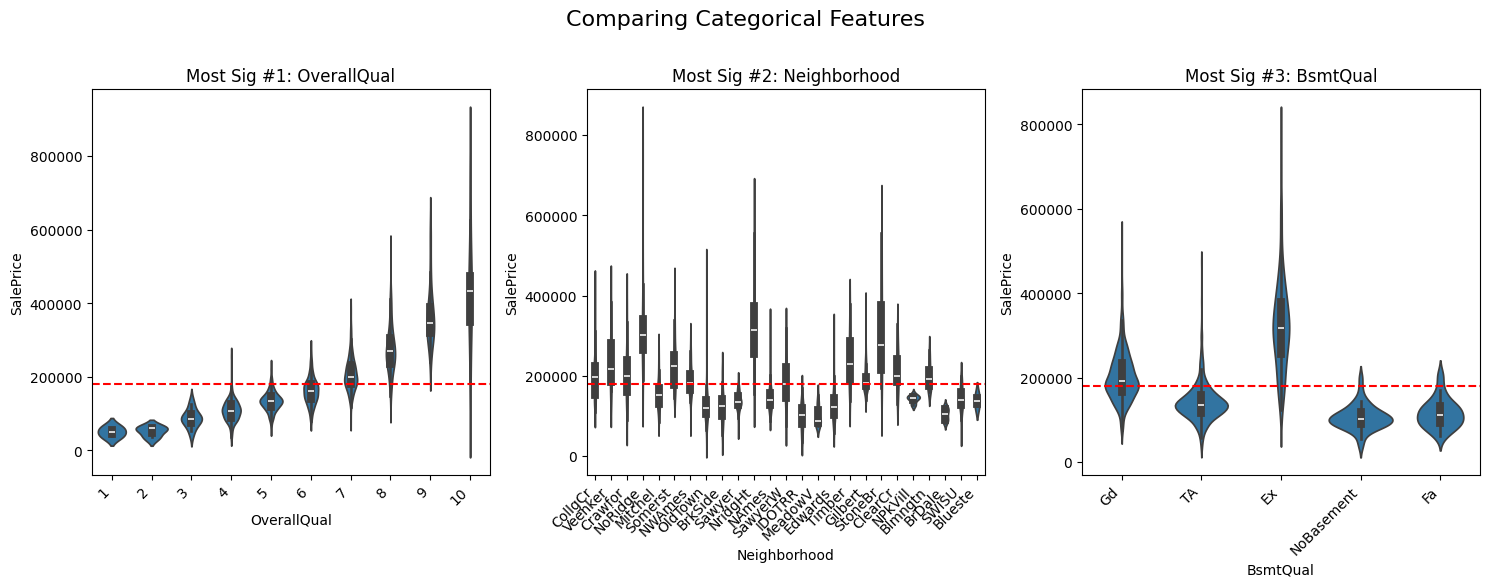


Individual Feature Statistics:
         Feature  F_statistic        p_value  r_squared  \
31   OverallQual  2436.770591  2.185675e-313   0.625652   
9   Neighborhood    71.784865  1.558600e-225   0.545575   
35      BsmtQual   316.148635  8.158548e-196   0.464994   

    Bonferroni significance    Price_Range  
31                     True  388438.388889  
9                      True  236718.846485  
35                     True  221388.149430  

Assessing joint significance of 3 features...
F-statistic: 143.6537
p-value: 0.000000
R-squared: 0.7445

Joint significance of selected features:
F-statistic: 143.6537
p-value: 0.000000
Joint R-squared: 0.7445


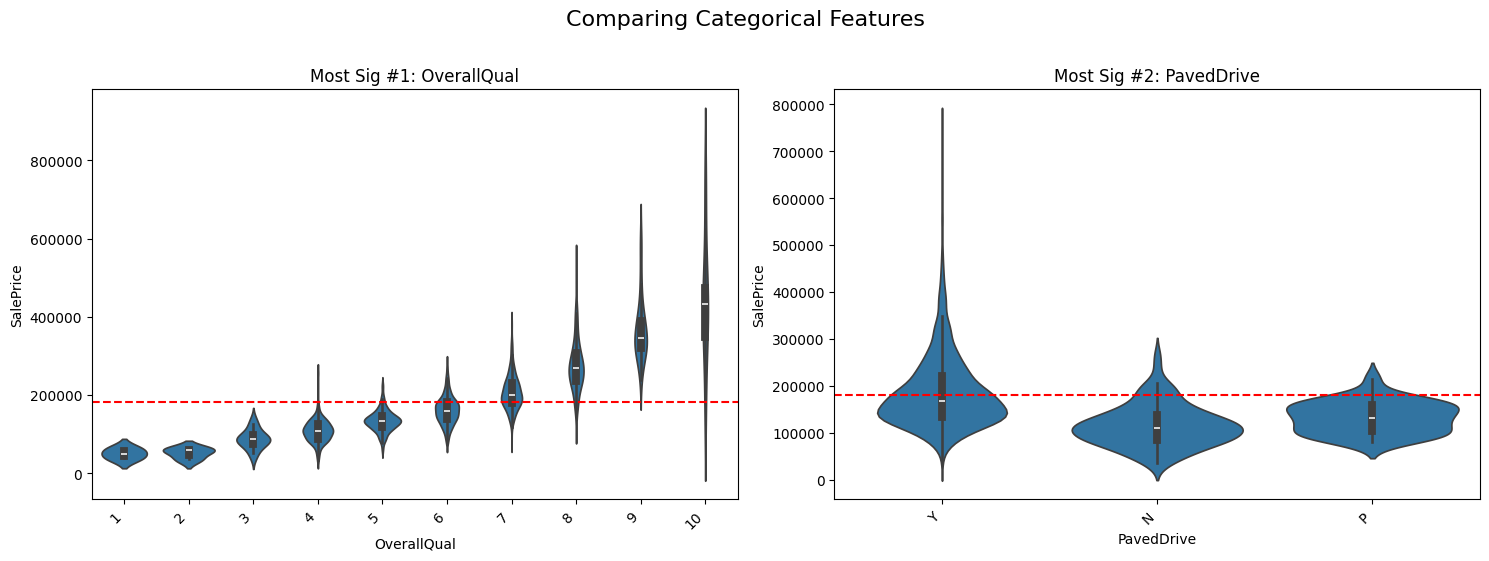


Individual Feature Statistics:
        Feature  F_statistic        p_value  r_squared  \
31  OverallQual  2436.770591  2.185675e-313   0.625652   
26   PavedDrive    42.024179   1.803569e-18   0.054540   

    Bonferroni significance    Price_Range  
31                     True  388438.388889  
26                     True   71394.851658  

Assessing joint significance of 2 features...
F-statistic: 821.2356
p-value: 0.000000
R-squared: 0.6285

Joint significance of selected features:
F-statistic: 821.2356
p-value: 0.000000
Joint R-squared: 0.6285


In [ ]:
print("\nComparing the significance of top selected features:")
analysis['compare_significance'](selected_features[:3])
print("\nComparing the significance of top and bottom selected features:")
analysis['compare_significance'](selected_features[:1]+selected_features[-1:])

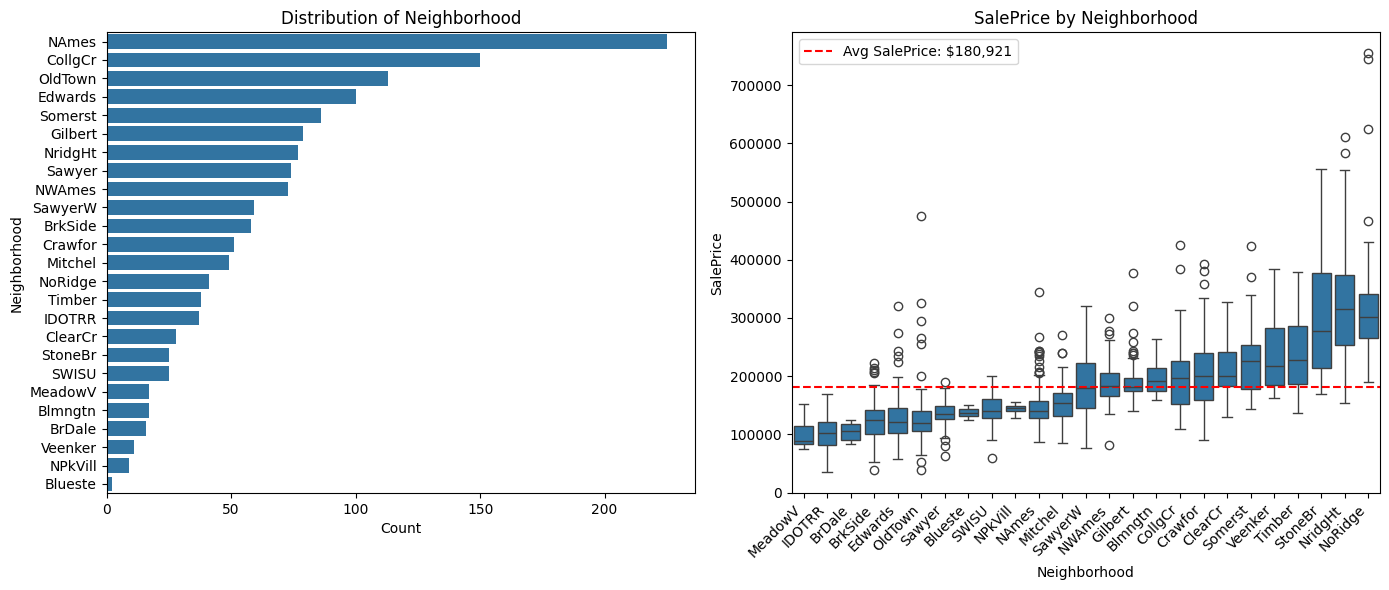


Statistics for Neighborhood:
              count           mean    median            std  % diff from avg
Neighborhood                                                                
NoRidge          41  335295.317073  301500.0  121412.658640             85.3
NridgHt          77  316270.623377  315000.0   96392.544954             74.8
StoneBr          25  310499.000000  278000.0  112969.676640             71.6
Timber           38  242247.447368  228475.0   64845.651549             33.9
Veenker          11  238772.727273  218000.0   72369.317959             32.0
Somerst          86  225379.837209  225500.0   56177.555888             24.6
ClearCr          28  212565.428571  200250.0   50231.538993             17.5
Crawfor          51  210624.725490  200624.0   68866.395472             16.4
CollgCr         150  197965.773333  197200.0   51403.666438              9.4
Blmngtn          17  194870.882353  191000.0   30393.229219              7.7
Gilbert          79  192854.506329  181000.0  

In [ ]:
analysis['analyze_feature']('Neighborhood')
